init = tf.initialize_all_variables() 는 tensor1.11이전 문법으로

현재는 init = tf.initializers.global_variables() 를 사용한다.

In [17]:
%pylab
%matplotlib inline
%load_ext watermark

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [18]:

import glob
import librosa
import tensorflow as tf

%watermark -v -m -p scipy,numpy,sklearn,tensorflow

CPython 3.5.6
IPython 7.7.0

scipy 1.1.0
numpy 1.15.2
sklearn 0.20.0
tensorflow 1.14.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-58-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [19]:
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
sound_data = np.load('urban_sound.npz')
X_data = sound_data['X']
y_data = sound_data['y']
X_data.shape, y_data.shape

((8732, 193), (8732, 10))

In [20]:
from sklearn.model_selection import train_test_split
X_sub, X_test, y_sub, y_test = train_test_split(X_data, y_data, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_sub, y_sub, test_size=0.2)
len(X_train), len(X_val), len(X_test), len(y_train), len(y_val), len(y_test)

(5588, 1397, 1747, 5588, 1397, 1747)

In [21]:
X_train.shape, y_train.shape

((5588, 193), (5588, 10))

In [26]:
training_epochs = 1000
n_dim = 193
n_classes = 10
n_hidden_units_one = 300
n_hidden_units_two = 200
n_hidden_units_three = 100
learning_rate = 0.1
sd = 1 / np.sqrt(n_dim)

In [27]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim, n_hidden_units_one], mean=0, stddev=sd), name="w1")
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean=0, stddev=sd), name="b1")
h_1 = tf.nn.sigmoid(tf.matmul(X, W_1) + b_1)

W_2 = tf.Variable(tf.random_normal([n_hidden_units_one, n_hidden_units_two], mean=0, stddev=sd), name="w2")
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean=0, stddev=sd), name="b2")
h_2 = tf.nn.tanh(tf.matmul(h_1, W_2) + b_2)

W_3 = tf.Variable(tf.random_normal([n_hidden_units_two, n_hidden_units_three], mean=0, stddev=sd), name="w3")
b_3 = tf.Variable(tf.random_normal([n_hidden_units_three], mean=0, stddev=sd), name="b3")
h_3 = tf.nn.sigmoid(tf.matmul(h_2, W_3) + b_3)

W = tf.Variable(tf.random_normal([n_hidden_units_three, n_classes], mean=0, stddev=sd), name="w")
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd), name="b")
y_ = tf.nn.softmax(tf.matmul(h_3, W) + b)

init = tf.initializers.global_variables()

cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

In [28]:
cost_history = np.empty(shape=[1],dtype=float)
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        _,cost = sess.run([optimizer, cost_function], feed_dict={X: X_sub, Y: y_sub})
        cost_history = np.append(cost_history,cost)
    
    print('Validation accuracy: ',round(sess.run(accuracy, feed_dict={X: X_test, Y: y_test}) , 3))
    saver.save(sess, "model_adam.ckpt")

Validation accuracy:  0.689


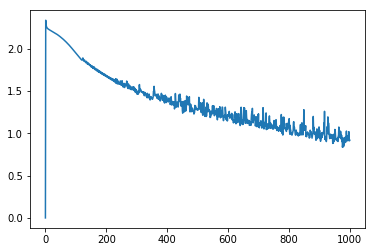

In [29]:
plt.plot(cost_history)